# Generate seg and flow images

Same code as TimeLapseData2d

In [78]:
%%capture

import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# filename = '/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d_151119-nmy2GFP-tagRfpPH-wt-04_w1LMM_488+488_LP_myTestCrop_bgrem.tif'
# filename = '/Users/jug/Dropbox/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
filename = '/Users/jug/Repositories/GIT/BobSeg/data/MAX_LP320-06-08_Concat-51-100.tif'
#filename = '/home/hp/git/BobSeg/data/MAX_LP320-06-08_Concat-1-50.tif'


stack = imread(filename)

segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

max_rs = (segchannel[0].shape[1] / 4,
          segchannel[0].shape[1] / 4)

min_rs = (25,25)

data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

cell = data.init_object("cell 1")
objects.append(cell)

data.add_object_at( cell, min_rs, max_rs, frame=0, seed=(170,250), segment_it=True )
data.track(cell, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

data.segment2dt( cell, max_radial_delta=2 );

segimgs = data.create_segmentation_image()

# Display segmented boundary

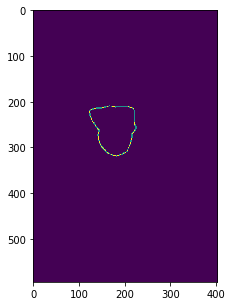

In [79]:
pylab.rcParams['figure.figsize'] = (4, 5)
imshow(segimgs[0])

# Import flow and segment images

In [80]:
data.compute_flow( flowchannel );

seg = segimgs
flow = np.swapaxes(np.swapaxes(data.flows,1,3),2,3)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  ...done!


# Dispalying Flow in X and Y for first frame 

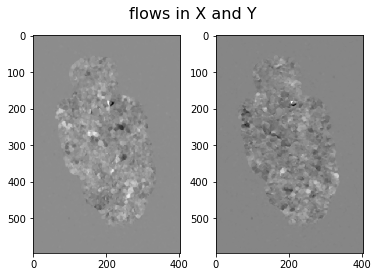

In [81]:
flow_x = np.swapaxes(flow,0,1)[0]
flow_y = np.swapaxes(flow,0,1)[1]

pylab.rcParams['figure.figsize'] = (6, 4)
fig = plt.figure()
fig.suptitle('flows in X and Y', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(flow_x[1], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flow_y[1], plt.get_cmap('gray'))

## Getting boolean array of interior points

In [88]:
def compute_cell_interior(fid, oid=0):
    in_points = []
    polygon = Polygon(data.get_result_polygone_2dt(oid, fid))
    size_x, size_y = shape(flow_x[0])[0], shape(flow_x[0])[1]
    flag = numpy.full((size_x, size_y), False, dtype=bool)

    for i in range(size_x):
        for j in range(size_y):
            point = Point(j,i)
            flag[i][j] = polygon.contains(point)
            if flag[i][j]:
                in_points.append((j,i))
    return in_points, flag

## Generate Random points and recording their trajectories

In [84]:
def plot_start_end(fig, points):
    ax=fig.add_subplot(1,1,1)
    st_en = []
    ax.imshow(flag, plt.get_cmap('gray'))

    st_en.append((points[0][0], points[0][1]))
    st_en.append((points[-1][0], points[-1][1]))
                
    ax.scatter(points[0][0], points[0][1])
    ax.scatter(points[-1][0], points[-1][1], c='r', s= 40, marker= 'o' )
    
    ax.plot(*zip(*st_en))


In [85]:
def plot_trajectory(fig, points, color='#00FF00'):
    ax=fig.add_subplot(1,1,1)
    segment = []
    ax.imshow(flag, plt.get_cmap('gray'))

    for i in range(len(points)-1):
        segment.append((points[i][0], points[i][1]))
        segment.append((points[i+1][0], points[i+1][1]))
                
        if i==0:
            ax.scatter(points[i][0], points[i][1], color=color, s=20, marker= 'o')
        #ax.scatter(points[i+1][0], points[i+1][1], color=color, s=10, marker= 'x' )
        if i==len(points)-2:
            ax.scatter(points[i+1][0], points[i+1][1], c='r', s=40, marker= 'o' )
    
        ax.plot(*zip(*segment), color=color, linewidth=.5)


In [97]:
def compute_trajectories(flow_x, flow_y, rand_p, epochs=100):
    traj  = []
    for k in range(len(rand_p)):
        pos_x = in_points[rand_p[k]][1]
        pos_y = in_points[rand_p[k]][0]
        int_x = int(round(pos_x))
        int_y = int(round(pos_y))
        epoch = 0
        temp = []
        while flag[int_x][int_y] and epoch<epochs:
            int_x = int(round(pos_x))
            int_y = int(round(pos_y))
            temp.append( ( int_y, int_x ) )
            pos_x += flow_x[int_x][int_y]
            pos_y -= flow_y[int_x][int_y]
            epoch=epoch+1
        traj.append(temp)
        plot_trajectory(fig, temp, color=col)
    return traj

frame = 45
in_points, flag = compute_cell_interior(frame)
np.random.seed(79)
rand_p = np.random.randint(0,len(in_points),20)
traj = compute_trajectories(flow_x[frame], flow_y[frame], rand_p, epochs=250)

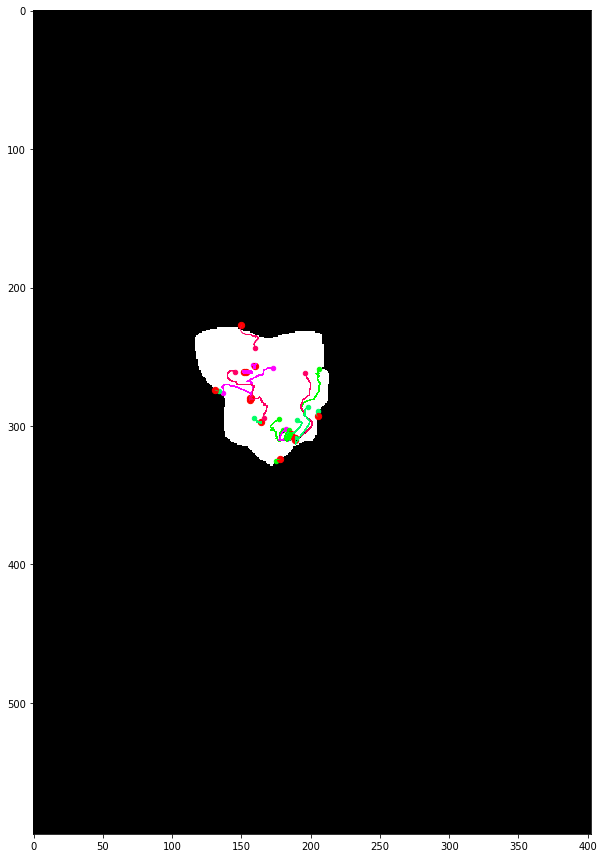

In [99]:
pylab.rcParams['figure.figsize'] = (10, 16)
fig=plt.figure()

colors=["#FF00FF", "#00FF00", "#FF0066", "#00FF66"]

for i in range(len(traj)):
    col = colors[i%len(colors)]
    plot_trajectory(fig, traj[i][:], color=col)

Checking whether interior points are correctly captured

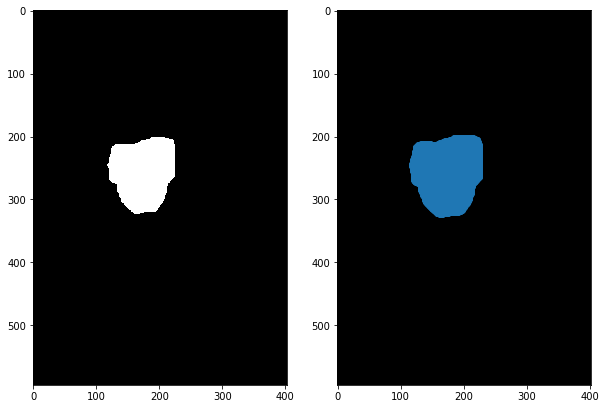

In [19]:

pylab.rcParams['figure.figsize'] = (10, 8)
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
ax.imshow(flag, plt.get_cmap('gray'))

ax=fig.add_subplot(1,2,2)
ax.imshow(flag, plt.get_cmap('gray'))
ax.scatter(*zip(*in_points))

## Plotting start and end points of trajectory of random points

start => blue in color 
end => red in color

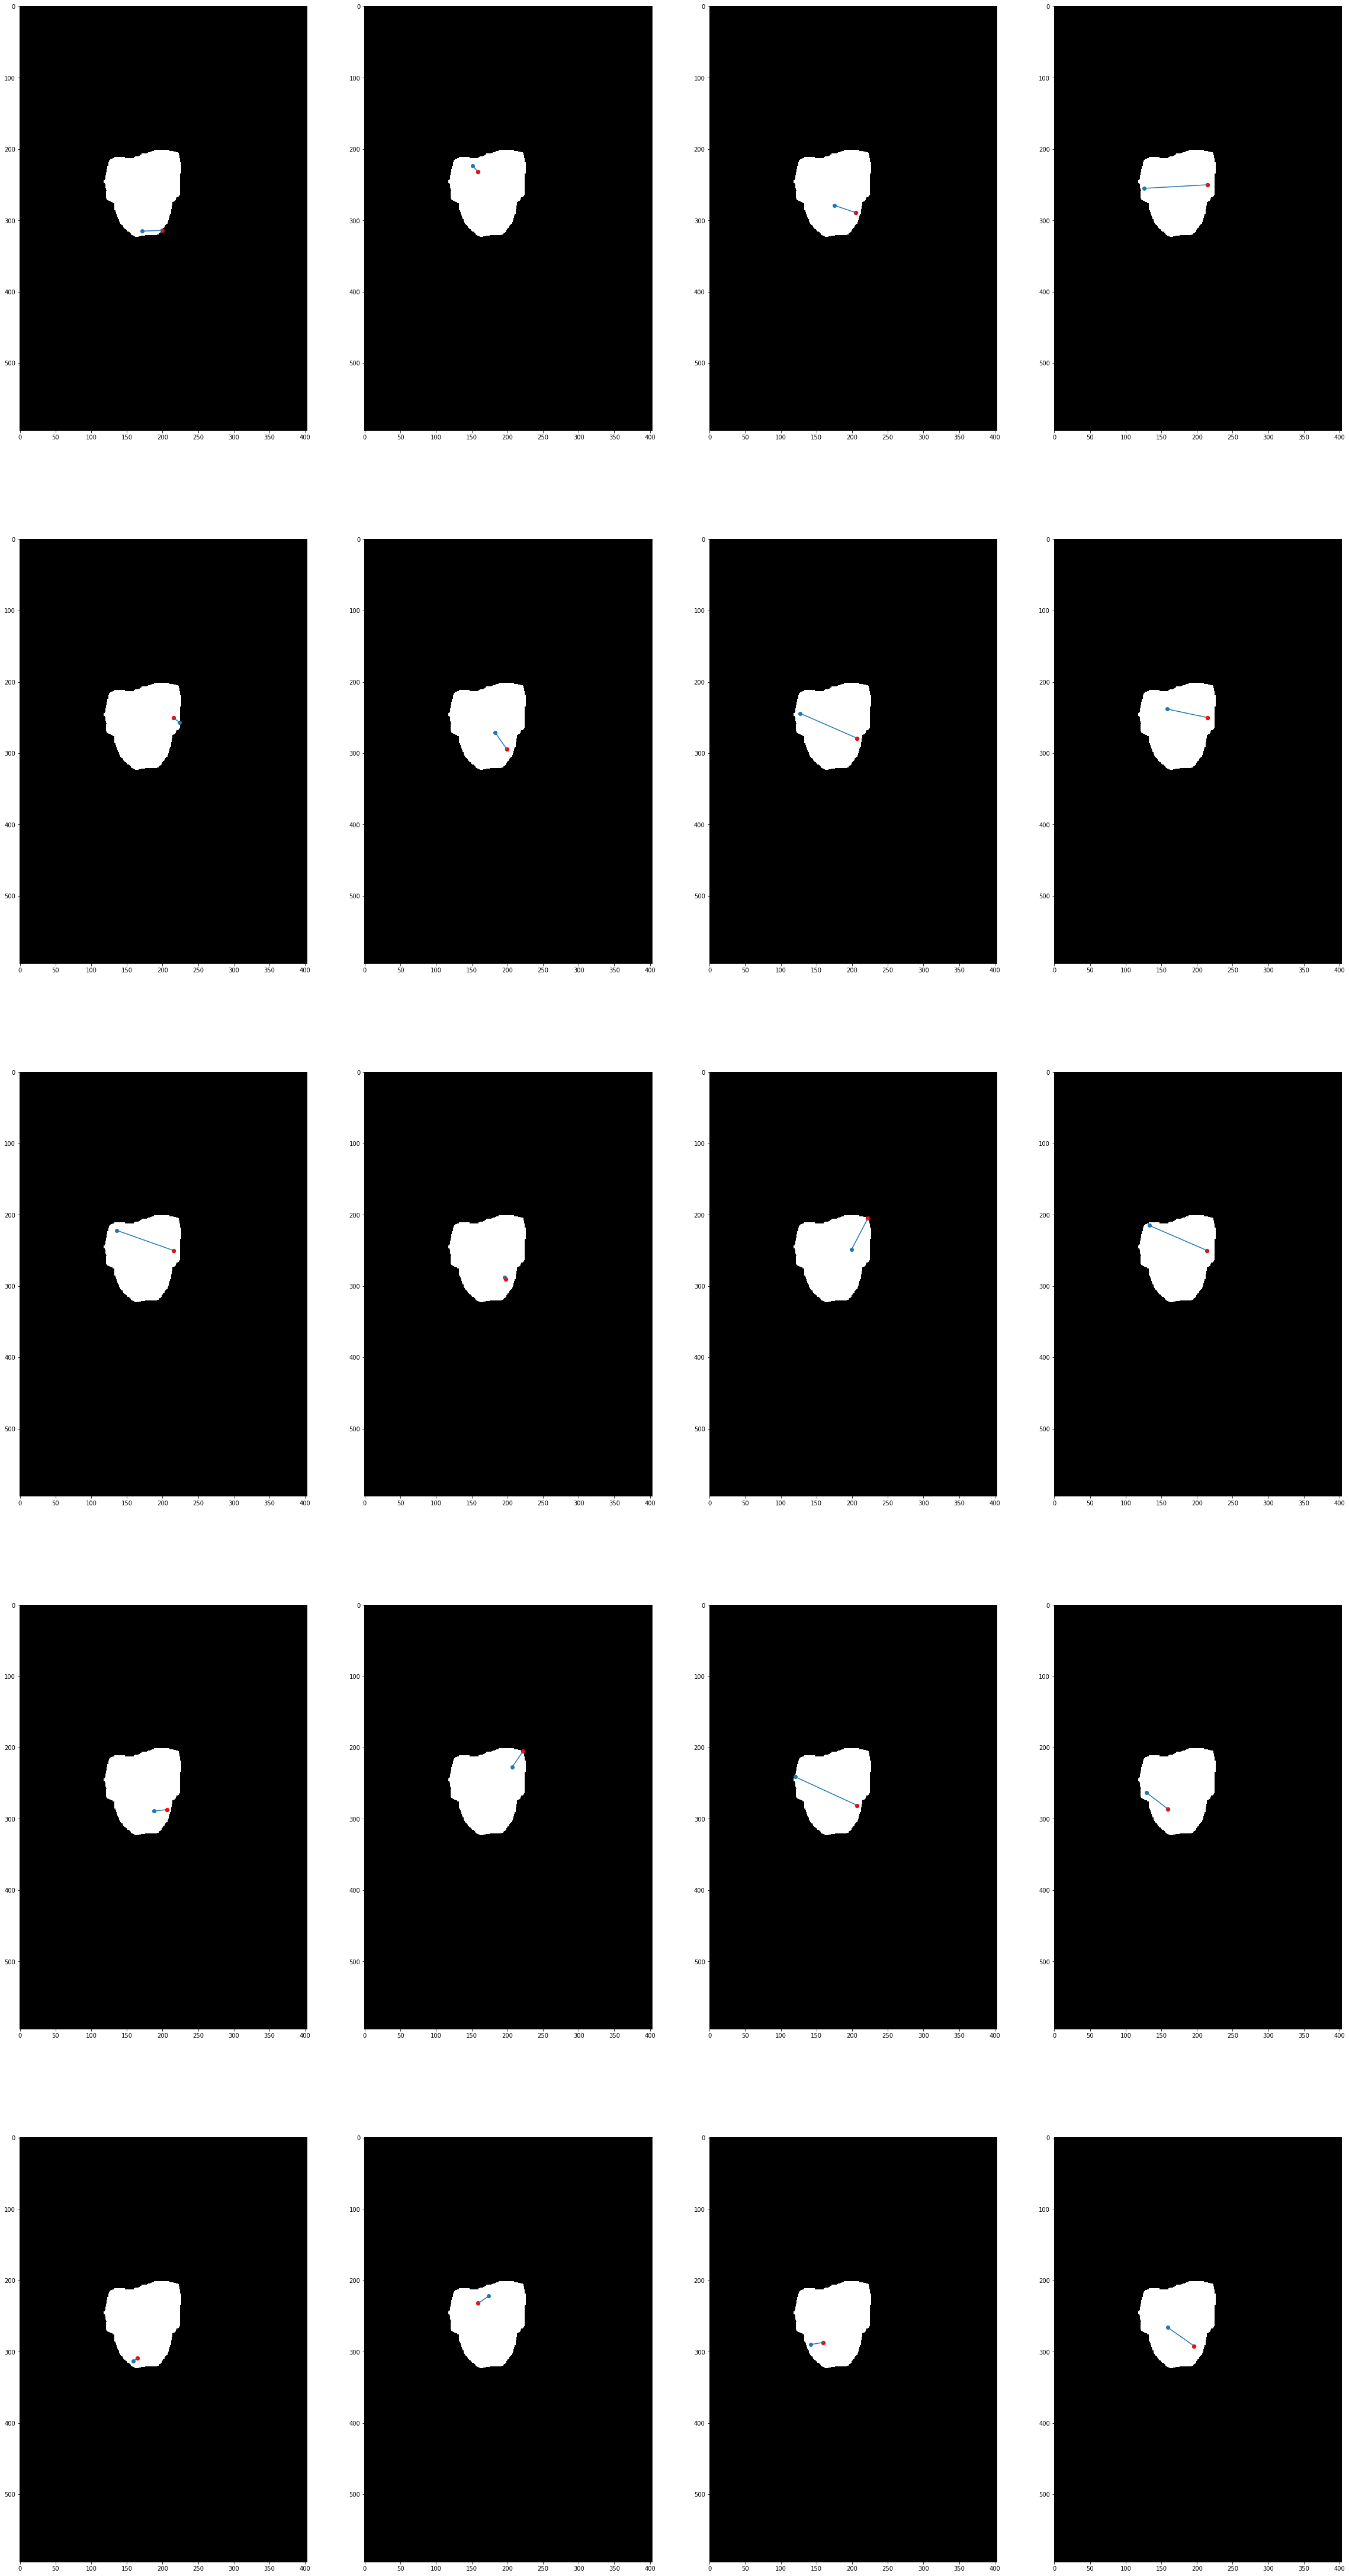

In [20]:
pylab.rcParams['figure.figsize'] = (40, 80)
fig=plt.figure()
for k in range(len(rand_p)):
   
    ax=fig.add_subplot(5,4,k+1)
    st_en = []
    ax.imshow(flag, plt.get_cmap('gray'))
    temp = traj[k]
    # put a blue dot at (10, 20)
    st_en.append((temp[0][0], temp[0][1]))
    st_en.append((temp[-1][0], temp[-1][1]))
                
    ax.scatter(temp[0][0], temp[0][1])
    
    # put a red dot, size 40, at len(temp) locations:
    #plt.scatter(*zip(*temp), c='r', s=40)
    
    ax.scatter(temp[-1][0], temp[-1][1], c='r', s= 40, marker= 'o' )
    
    ax.plot(*zip(*st_en))
    #ax.plt.show()
